In [1]:
import typing

class Circle:
    """
    Instance representation
    """
    def __init__(self, x: float, y: float, radius: float):
        self.x = x
        self.y = y
        self.radius = radius

    def __repr__(self):
        return f"Circle({self.x}, {self.y}, r={self.radius})"

    def __eq__(self, other):
        return self.x == other.x and  self.y == other.y and self.radius == other.radius

    def __hash__(self):
        return hash((self.x, self.y ,self.radius))

# simple plotting  helper
import matplotlib.pyplot as plt
def plot_circle(ax: plt.Axes, circle: Circle, **kwargs):
    patch = plt.Circle((circle.x, circle.y), radius=circle.radius, **kwargs)
    ax.add_patch(patch)

In [2]:
import gurobipy as gp  # requires gurobi to be installed via conda.
from gurobipy import GRB
def compute_tour(circle_sequence: typing.List[Circle], path: bool=False) -> typing.List[typing.Tuple[float ,float]]:
    """
    This function efficiently computes the optimal CE-Tour for a given sequence(!) of circles.
    If the order of circles is given, the problem becomes an easy to solve SOC-Program.
    The tour may implicitly cross circles earlier.

    Learn more about SOC: https://www.gurobi.com/events/gurobi-qcp-and-socp-optimizer-overview/
    :param circle_sequence: Sequence of circles (the exact order they are visited)
    :param path: Compute a path instead of a tour.
    :return: Sequence of coordinates of the tour. The coordinates may be slightly off (but not critical).
    """
    model = gp.Model()

    # tour points
    x = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    y = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # length of segments
    f = model.addVars(circle_sequence, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    model.setObjective(gp.quicksum(f.values()), sense=GRB.MINIMIZE)

    # x and y-length of segments (difference of segment points)
    w = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    u = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # difference of tour points to circle center
    s = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    t = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # SOC
    for c in circle_sequence:
        model.addQConstr(f[c]*f[c] >= w[c]*w[c] + u[c]*u[c])
        # tour points are within circle radius
        model.addQConstr(s[c]*s[c] + t[c]*t[c] <= c.radius*c.radius)

        # enforce s,t represent difference to circle center
        model.addConstr(s[c] == c.x - x[c])
        model.addConstr(t[c] == c.y - y[c])

    for i, c in enumerate(circle_sequence):
        if path and i==0:
            # for paths, the distance between the endpoints
            # is free
            model.addConstr(w[c]==0)
            model.addConstr(u[c]==0)
        else:
            # enforce w,u represent segment lengths (x and y axes)
            prev_c = circle_sequence[(i-1)%len(circle_sequence)]
            model.addConstr(w[c] == x[prev_c] - x[c])
            model.addConstr(u[c] == y[prev_c] - y[c])

    model.optimize()
    return [(x[c].X, y[c].X) for c in circle_sequence]

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-13
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8559U CPU @ 2.70GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 35 columns and 50 nonzeros
Model fingerprint: 0xb69461f7
Model has 10 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+00]
  QRHS range       [1e+00, 1e+00]
Presolve removed 10 rows and 10 columns
Presolve time: 0.01s
Presolved: 15 rows, 30 columns, 35 nonzeros
Presolved model has 10 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.500e+01
 Factor NZ  : 1.200e+02
 Factor Ops : 1.240e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective               

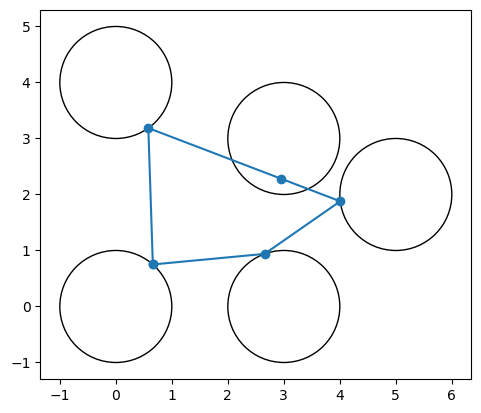

In [3]:
fig = plt.Figure(figsize=(10,10))
ax = plt.gca()
circles = [Circle(0,0, 1), Circle(3,0, 1), Circle(5, 2, 1), Circle(3,3, 1), Circle(0, 4, 1)]
tour = compute_tour(circles)
for c in circles:
    plot_circle(ax, c, facecolor="white", zorder=1, ec="black")
plt.plot([p[0] for p in tour]+[tour[0][0]], [p[1] for p in tour]+[tour[0][1]], 'o-')
ax.set_aspect('equal', 'box')
plt.show()